# Конкурентность

Структура занятия:

1) конкурентность и параллельность

2) threading и GIL

3) multiprocessing

4) асинхронность


## Конкурентность и параллелизм

Параллелизм - способность системы **одновременно** обрабатывать несколько задач

Конкурентность - несколько более широкий термин, чем параллелизм. Конкурентность предполагает, что несколько задач могут выполняться **перекрывающим** одна-другую образом. 

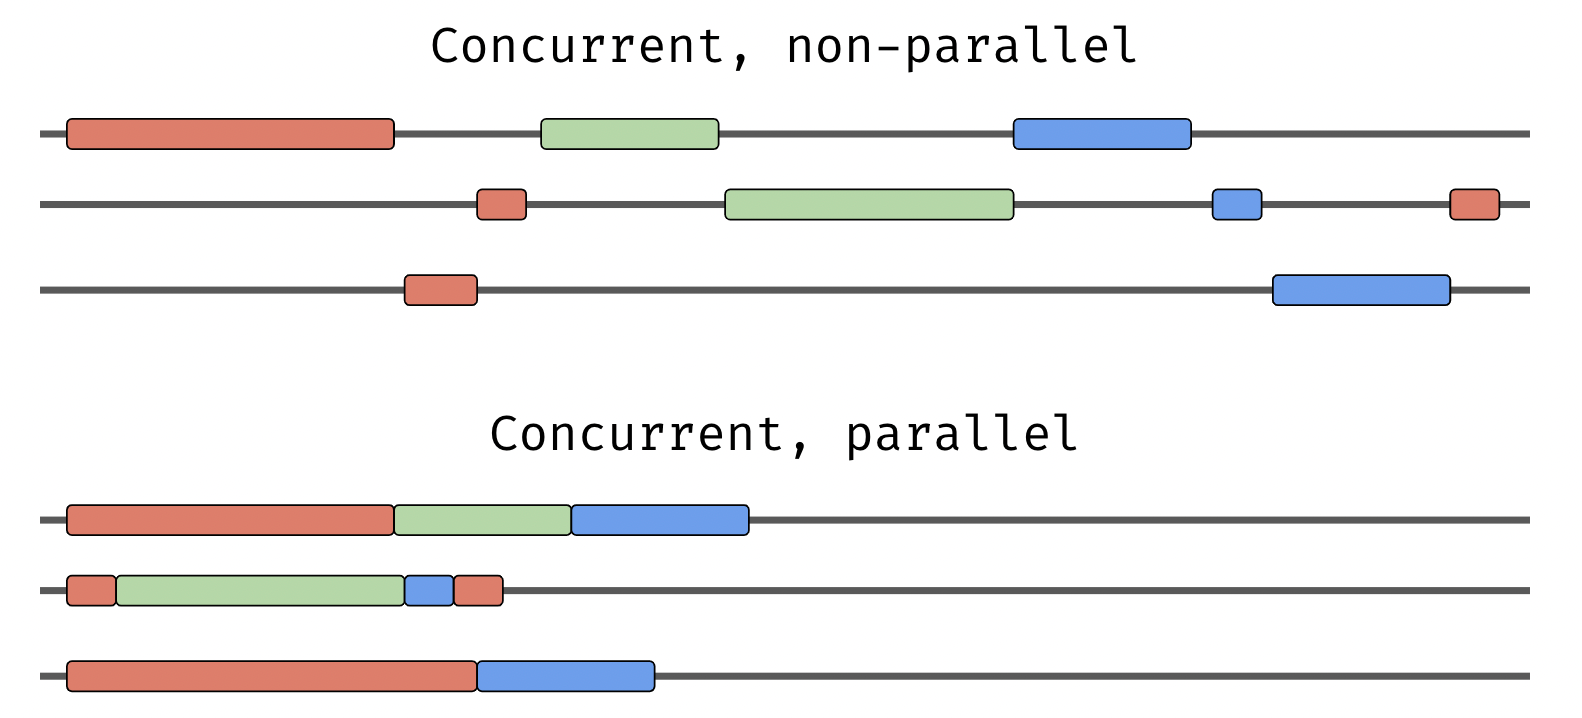

Конкурентность решает проблему ожидания (чего-либо, например ответа): мы можем не просто стоять на месте, а выполнять другие полезные задачи, пока ждём

Параллелизм решает вопрос повышения скорости обработки задач путём их распараллеливания на несколько работников

Таким образом, конкурентность подходит для задач, которые зависят от внешних ресурсов (внешних сервисов, баз данных, сети), параллелизм - для задач интенсивно использующих процессор

Есть ещё один интересный термин, который необходимо усвоить - многозадачность.

**Многозадачность** - возможность выполнять несколько задач одновременно (параллельно или псевдопараллельно), переключаясь (выделяя ресурсы) с одной задачи на другую. Многозадачность бывает вытесняющей и кооперативной. Вытесняющая многозадачность - управление переключением осуществляет оперционная система (управление осуществляется сверху). Кооперативная - следующая задача выполняется только после того, как текущая задача явно объявит себя готовой отдать ресурсы другим задачам (управление снизу)

Далее необходимо вспомнить о 2-х важнейших сущностях ОС, о потоках и процессах:
- Процесс (process) — это идентифицируемая абстракция совокупности взаимосвязанных системных ресурсов на основе отдельного и независимого виртуального адресного пространства в контексте которой организуется выполнение потоков. Каждый процесс имеет как минимум один поток. Также каждый процесс имеет свое собственное виртуальное адресное пространство и контекст выполнения, а потоки одного процесса разделяют адресное пространство процесса.
- Поток (thread) — это, сущность операционной системы, процесс выполнения на процессоре набора инструкций (программного кода). Общее назначение потоков — параллельное выполнение на процессоре двух или более различных задач. Планировщик ОС, руководствуясь приоритетом потока, распределяет кванты времени между разными потоками и ставит потоки на выполнение. Все потоки одного процесса разделяют одно адресное пространство.

Процесс > Поток

Разбираемся с Python. Каждый запущенный интерпретатор python - это отдельная программа, состоящая из 1-го процесса и только 1 потока. При этом, помимо основной работы интерпретатор выполняет набор сервисных функций:
- выделение памяти
- кеширование (они вечно живут, пока жив интерпретатор) самых часто используемых данных - коротких строк и небольших целых числел
- освобождение памяти. При этом используется очень простой счётчик ссылок и сборщик мусора (GC - garbage collector)

Для корректной работы очень простого счётчика ссылок в Python (считай, внутренностей интерпретатора) применяется GIL (Global Interpreter Lock или Глобальная Блокировка Интерпретатора) - это своеобразный мьютекс, работающий на уровне процесса Python, который ставится в основной цикл интерпретатора. Таким образом, в один момент времени только один поток может выполнять байт-код. Переключение потоков (с действующего на другие) может происходить по таймеру / если действующий поток стал ожидать (sleep) / если действующий поток пытается осуществить ввод-вывод / по исчерпании лимита инструкций у действующего потока.

## threading и GIL

Модуль `threading` позволяет управлять (создавать / закрывать) потоками OС. Как мы сказали выше, GIL в Python не позволяет потокам работать одновременно, тем не менее потоки могут выполяться конкурентно (переключаясь на ожиданиях). Таким образом, `threading` реализует не параллельную конкурентную вытесняющую (так как создаются обычные потоки ОС, управляемые самой ОС) многозадачность.

Что это значит - потоки подойдут для тех ситуаций, когда задачи много времени ожидают (`sleep`, ввода-вывода, в общем IO-Bound) и логически распараллеливаются, например - несколько сетевых запросов. Потоки в Python не подойдут для задач, в которых активно участвует CPU (CPU-Bound).

Также стоит помнить, о том что максимальное число потоков в ОС ограничено, как нарочно, скажем, числом дескрипторов (65к), так и естественно, например размером стека (8176 Б). Кроме того, переключение между потоками - это не простая операция, и чем больше потокв в 1 процессе, тем более она дорогостоящая.

Так как потоки работают в одном адресном пространстве, каждый поток может обратиться ко всему множеству объектов программы.

Начнём с рассмотрения последовательного варианта

In [ ]:
import requests
import time

urls = [
    "https://imdb.com",
    "https://python.org",
    "https://google.com",
    "https://docs.python.org/",
    "https://wikipedia.org",
]

def function(url, results):
    resp = requests.get(url)
    results.append(resp.status_code)
    
def main():
    now = time.time()
    results = []  
    for i in urls:
        function(i, results)    
    print(results)
    print(f'Скрипт выполнялся {time.time() - now:.2} секунд')
    
main()

Испольуем `threading`

In [ ]:
import threading
import requests
import time

def main():
    now = time.time()
    threads = []
    results = []
    
    for i in range(len(urls)):  # создадим число потоков по числу задач
        x = threading.Thread(target=function, args=(urls[i], results))  # синтаксически функция и аргументы разделены
        threads.append(x)
        x.start()  # стартуем поток

    for i, thread in enumerate(threads):
        thread.join()  # поток необходимо закрыть (соединить с основным) после работы
        
    print(results)
    print(f'Скрипт выполнялся {time.time() - now:.2} секунд')
    
main()

Другой способ работы с потоками - использовать модуль `concurrent.futures`

In [ ]:
from concurrent.futures import ThreadPoolExecutor

def main():
    now = time.time()
    results = []
    
    with ThreadPoolExecutor(max_workers=3) as executor:  # создадим пул, состоящий из 3 потоков
        for url in urls:
            executor.submit(function, url, results)  # есть и другой полезный метод - map
            
    print(results)
    print(f'Скрипт выполнялся {time.time() - now:.2} секунд')
    
main()

Такая организация кода позволяет равномерно распределить нагрузку между фиксированным числом потоков. Мы создали 3 потока, и даже если у нас будет какая-либо долгая задча, она займёт только 1 поток, остальные 2 смогут переварить другие (более быстрые) задачи

Как и в любой другой многопоточной программе, в python возможна ситуация гонки потоков. Для того чтобы спраиться с этим явлением, предусмторенны средства синхронизации.
- `threading.Lock` - обычный мьютекс
- `threading.RLock` - повторно используемый мьютекс
- `threading.Event` - событие
- `threading.Condition` - условие
- `threading.Semaphore` - семафор

Рассмотрим пример с гонкой

In [ ]:
result = 0  # покажем что все потоки имеют 1 адресное простанство

def function():
    global result
    r = result  # result - общий ресурс для потоков
    time.sleep(1)
    result = r + 1

    
def main():  
    with ThreadPoolExecutor(max_workers=5) as executor:
        for _ in range(10):
            executor.submit(function)
    print(result)
    
main()

Простая блокировка позволит получить ожидаемый результат

In [ ]:
from threading import Lock

mu = Lock()  # блокировка должна быть создана до вызова потоков
result = 0

def function():
    with mu:
        global result
        r = result
        time.sleep(1)
        result = r + 1

    
def main():  
    with ThreadPoolExecutor(max_workers=5) as executor:
        for _ in range(10):
            executor.submit(function)
    print(result)
    
main()

Интересно, что некоторые библиотеки Python для ускорения производительности работают со снятым GIL, например - `pandas`

## multiprocessing

Модуль `multiprocessing` позволяет управлять (создавать / закрывать) процессами OС. GIL не имеет власти над процессами. Процессы позволяют реализовать настоящую параллельную конкурентную (так как если число действующих процессов превысит число ядер CPU, они начнут конкурировать за процессорное время) вытесняющую (так как создаются обычные процессы ОС - считай, новые интерпретаторы) многозадачность.

Процессы это очень крупные объекты ОС. Переключение между процессами - сложная и очень дорогостоящая операция. Эффективное число процессов в программе <= общего числа ненагруженных ядер CPU.

Это значит что процессы подойдут для тех ситуаций, когда задачи требуют большой вычислительной работы (CPU-Bound) и логически распараллеливаются, например  - преобразование множества изображений / расчёт множества криптографических хешей. 

`multiprocessing` может быть использован для IO-Bound задач, как Threading, но прирост в производительности будет ограничен числом ядер с одной стороны, и сложностью переключения процессов с другой. Вплоть до максимального количества ядер в системе, распараллеливание посредством мультипроцессинга будет примерно таким же как и с импользованием многопоточности (с аналогичным числу ядер числом потоков)

Для начала рассмотрим последовательный вариант

In [ ]:
from hashlib import sha512

args = [
    'pass',
    'passwd',
    'MyPassw',
    'MyPasswd123',
    'p',
    'a',
]

def p_function(a: str, results):
    b = a.encode()
    for i in range(1_000_000):      
        b = sha512(b).hexdigest().encode()
    results.append(b.decode())

def main():
    now = time.time()
    results = []
    
    for i in args:
        p_function(i, results)
        
    for h in results:
        print(h)
    print(f'Скрипт выполнялся {time.time() - now:.2} секунд')
        
main()

Покажем неэффективность потоков

In [ ]:
def main():
    now = time.time()
    results = []
    
    with ThreadPoolExecutor(max_workers=3) as executor:
        for password in args:
            executor.submit(p_function, password, results)
            
    for h in results:
        print(h)
    print(f'Скрипт выполнялся {time.time() - now:.2} секунд')
    
main()

Покажем эффективность процессов. Будем использовать `ProcessPoolExecutor` из модуля `concurrent.futures`

Обратим внимание на некоторые особенности использования:
- исполняемый модуль обязательно должен иметь функцию верхненго уровня `main()`, и точку входа `if __name__ == '__main__'`
- данные, оправляемые в дочерние процессы должны быть сериализуемы с помощью Pickle
- дочерние процессы копируются при помощи процедуры fork - это значит что работает оптимизация CopyOnWrite

In [ ]:
%%file process_sample1.py
from concurrent.futures import ProcessPoolExecutor
import time
from hashlib import sha512

args = [
    'pass',
    'passwd',
    'MyPassw',
    'MyPasswd123',
    'p',
    'a',
]

global_results = []  # мы не сможем получить доступ к этой области памяти в дочерних процессах!

def p_function(a):
    global global_results
    b = a.encode()
    for i in range(1_000_000):      
        b = sha512(b).hexdigest().encode()
    global_results.append(b.decode())  # это не будет иметь эффекта
    return a, b.decode()


def main():
    now = time.time()
    global global_results
    
    with ProcessPoolExecutor(max_workers=3) as executor:  # создадим пул, состоящий из 3 процессов
        results = executor.map(p_function, args)
            
    for h in results:
        print(h)
    print(global_results)  # тут будет пусто
    print(f'Скрипт выполнялся {time.time() - now:.2} секунд')
    
if __name__ == '__main__':  # ОБЯЗАТЕЛЬНО оформлять код, выполняемый с помощью мультипрочессинга таким способом
    main()

In [ ]:
!python process_sample1.py

Пример с использованием модуля `multiprocessing`.

Также задействуем тут объект `Manager`, который позволяет создать доступные дочерним процессам данные. В нашем случем создадим простой объект `Value` целочисленного типа и мьютекс `Lock`. 

Обратите внимание, модуль `multiprocessing` также содержит средства синхронизации, в том числе и `Lock`, но такой мьютекс может быть использован только через инициализацию дочернего процесса, в то время как `multiprocessing.Manager.Lock` досупен даже будучи переданным как аргумент распараллеливаемой функции

In [ ]:
%%file process_sample2.py
from multiprocessing import Pool, Manager
import time

def processing_function(args):
    x, counter, mu = args
    
    with mu:  # предотвратим гонку
        counter.value += x
    
#     counter.value += x

def main():
    m = Manager()
    counter = m.Value('i', 0)
    mu = m.Lock()
    with Pool(10) as p:
        p.map(processing_function, ((10, counter, mu) for x in range(10)))
    print(counter)


if __name__ == "__main__":
    main()

In [ ]:
!python process_sample2.py

Так как каждый процесс функционирует в изолированном адресном пространстве, данные между процессами невозможно передавать напрямую. Сдедства (способы), которые служат для передачи данных между процессами:
- через файлы или любые другие внешние ресурсы (очереди, базы данных и т.п.)
- через SharedMemory https://docs.python.org/3/library/multiprocessing.shared_memory.html
- через Manager, но этот подход считается не оптимальным
- через пайпы и очереди https://docs.python.org/3/library/multiprocessing.html#pipes-and-queues

## асинхронность

Модуль `asyncio` и специализированные модули для асинхронной работы с сетевыми объектами позволяют управлять (создавать, запускать, ожидать, закрывать) корутинами (сопрограммами). В основе работы асинхронности лежит Цикл событий (**Event Loop**), который взаимодействует с корутинами, так чтобы каждая из них выполнялась оптимальное время, при этом управляет потоком выполнения разработчик (= сама программа) при помощи специальных инструкций `async` / `await` и некоторых других. Цикл событий работает в 1 потоке Python, а значит на него накладываются ограничения GIL. Цикл событий позволяет реализовать не параллельную конкурентную кооперативную многозадачность.

С точки зрения ОС в основе работы асинхронности лежит API мультиплексированного ввода-вывода (конкретные реализации зависят от ОС - SELECT, POLL, EPOLL, Kqueue, IOCP), API позволяет приложениям осуществлять мониторинг нескольких открытых файловых дескрипторов (которые могут быть файлами, устройствами или сокетами, в том числе сетевыми), для того, чтобы узнать, готово ли устройство для продолжения ввода (вывода).

Корутины это очень маленькие объекты Python. Переключение между корутинами - очень быстрая операция (зависит от реализации - от O(1) до O(n)). Эффективное число корутин в программе определяется ограничениями сети и системы.

Это значит что асинхронность подойдёт для тех ситуаций, когда задачи много времени ожидают сеть и логически распараллеливаются. Асинхронность в Python не подойдёт для задач, в которых активно участвует CPU (CPU-Bound) и IO операции отличны от сетевых (например, задача чтения с диска).

Напоминаю, что с корутинами (сопрограммами) мы познакомились ещё в занятии про функции, в разделе "генераторы" - первоначально (до версии python3.6) корутины синтаксически реализовывались именно при помощи конструкций `yield`, `yield from`, `x = yield`

Ошибка: простое добавление синтаксических интсрукций async/await и запуск цикла событий не сделают код асинхронным

In [ ]:
import asyncio
import requests
import time

urls = [
    "https://imdb.com",
    "https://python.org",
    "https://google.com",
    "https://docs.python.org/",
    "https://wikipedia.org",
]

async def other_async_fun():
    """имитация, например, ещё одного сетевого вызова"""
    await asyncio.sleep(1)

async def async_function(url, results):  # объявляем корутину
    resp = requests.get(url)
    await asyncio.sleep(1)
    results.append(resp.status_code)

async def main():  # объявляем корутину
    now = time.time()
    results = []  
    
    for i in urls:
        await async_function(i, results)
        
    print(results)
    print(f'Скрипт выполнялся {time.time() - now:.2} секунд')
    
await main()  # выполняем корутину - в IDE необходимо использовать asyncio.run(main())

Для того чтобы использовать асинхронные возможности языка, необходимо использовать асинхронные библиотеки, мы в качестве клиента будем использовать `httpx`.

Кроме того, задачи необходимо ставить циклу событий на исполнение при помощи функций:
- `await gather()` - планирует и ожидает задачи (самый широко используемый способ)
- `await wait_for()` - запускает с таймаутом
- `create_task()` - оборачивает корутину в объект типа `Task` и запускает задачу
- `to_thread()` - асинхронно выполняет задачу в другом потоке
- прочих - https://docs.python.org/3/library/asyncio.html

Если корутину нужно обработать внутри задачи, уже поставленной Циклу событий на исполнение, её можно вызвать при помощи простой инструкции `await` 

In [ ]:
pip install httpx

In [ ]:
import httpx

async def other_async_fun():
    """имитация, например, ещё одного сетевого вызова"""
    await asyncio.sleep(1)

async def async_function(client, url, results):
    r = await client.get(url, follow_redirects=True)
    await other_async_fun()  # <- вот тут корутина исполняется асинхронно
    results.append(r.status_code)

async def main():
    now = time.time()
    results = []  
    
    async with httpx.AsyncClient() as client: # асинхронный клиент может использовать неблокирующие сокеты
        coros = []
        for i in urls:
            coros.append(async_function(client, i, results))      
        await asyncio.gather(*coros)  # gather поставит корутины на исполнение Циклу событий
    
        
    print(results)
    print(f'Скрипт выполнялся {time.time() - now:.2} секунд')
    
await main()

Для эффективной работы с asyncio необходимо помнить о том что сеть это тоже ресурс, кроме того требуется знать особенности системы на которой будет выполняться код, учитывать что сессии (как и соединения) это весьма крупные объекты и их лучше переиспользовать. Всегда необходимо ограничивать колличество одновременно запускаемых сопрограмм.

Модуль asyncio содержит стандартные инструменты синхронизации: Lock, Event, Condition

Некоторые (наиболее популярные) асинхронные библиотеки: https://github.com/aio-libs
